# Exploratory Data Analysis

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm

## Inspecting the Data

In [2]:
# Import the data
df = pd.read_csv('query.csv')

In [3]:
# Dropping records that are different only in terms of internal ID 
df = df.drop_duplicates('mediaId')

In [4]:
# Check dimensions
df.shape

(3208, 36)

In [5]:
# Check first few rows
pd.set_option('display.max_columns', 500)
df.head()

,internalId,mediaId,title,beginTimeCET,channel,skoClassL1,skoClassL2,npoCCCDomainDef,npoCCCDef,npoZapp,broadcasters,min_age_classification,duration,first_broadcaster,is_nos_content,AggregatedText,start,avg_kdh,fans,fansChange,ownPosts,ownPostsComments,ownPostsEngagement,ownPostsEngagementRate,pageEngagedUsers,pageImpressions,pageImpressionsUnique,pageImpressionsPaidUnique,pagePostEngagements,pageFans,pageFansChange,pageViewsTotal,pageEngagementRateUnique,pagePositiveFeedbackEngagementRate,pageFansOnlinePerDay,sum_weighted_comments
0,112305280,VPWON_1311778,Zomergasten,2020-08-16 20:20:00,NPO 2,NON FICTIE,OVERIGE NON FICTIE,opinie,meningsvorming,False,VPRO,NaN,10745016,VPRO,False,"888 LIVEPROGRAMMA, ONDERTITELING KAN ACHTERLOP...",no_start,4.006667e+05,43327.741667,-1.663866,0.221918,14.068493,88.265753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1215.75
1,113021287,VPWON_1314484,Iedereen verlicht,2020-10-11 16:29:00,NPO 2,NON FICTIE,OVERIGE NON FICTIE,samenleving,religie,False,NTR,NaN,1509144,NTR,False,"888 Ga je erin, Jan? Ja. Ik durf het eigenlijk...",no_start,3.892857e+04,3534.758454,6.344660,0.624658,3.142466,33.460274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.75
2,112035904,VPWON_1311775,Zomergasten,2020-07-26 20:18:00,NPO 2,NON FICTIE,OVERIGE NON FICTIE,opinie,meningsvorming,False,VPRO,NaN,11072760,VPRO,False,888 Ze is al meer dan 40 jaar strafrechtadvoca...,no_start,4.006667e+05,43344.141414,-1.724490,0.221918,14.068493,88.265753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1378.00
3,115257225,BV_101404366,Kassa,2021-04-10 19:06:00,NPO 1,NON FICTIE,OVERIGE NON FICTIE,kennis,service,False,BNNVARA,NaN,2731752,BNVA,False,888 SIRENE Drie uur spandoek klaar! Ja? Zijn j...,no_start,1.212919e+06,89244.712963,5.277778,1.424658,74.638356,164.252055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.50
4,109725184,POW_04501861,Jeugdjournaal avond,2020-01-23 19:00:00,NPO 3,KINDEREN (0 t/m 12 jaar),Kinderen: non fictie,nieuws,nieuws,True,NOS,9.0,1267929,NOS,True,In China heeft de regering een paar megagrote ...,no_start,2.363578e+05,NaN,NaN,0.027473,0.280220,1.697802,0.000282,167.373626,3443.813187,2380.167582,197.043956,234.39011,26936.596154,5.324176,63.89011,0.081743,0.013366,24130.419718,20.00


In [6]:
# Drop things that are not features and save ids
ids = df.mediaId
df = df.drop(["internalId", "mediaId", "beginTimeCET", "AggregatedText", 'broadcasters'], axis=1)

## Correlated Features

In [7]:
# Checking for high multicollinearity
corr_df = df.corr()
high_mc = []
for i in np.arange(0,corr_df.shape[0]):
    for j in np.arange(0, corr_df.shape[1]):
        if corr_df.iloc[i,j] >= 0.80 and i != j:
            high_mc.append([i,j])
print(len(high_mc))

32


In [8]:
# Dropping highly correlating features
df = df.drop(['ownPostsEngagement', 'pageEngagedUsers', 'pagePostEngagements', 'pageFansOnlinePerDay', 'pageImpressions', 'pageImpressionsUnique', 'pagePositiveFeedbackEngagementRate'], axis=1)

## Missing Values

In [9]:
# Check for missing values
round(df.isna().sum()/df.shape[0],5).sort_values(ascending=False).head(10)

min_age_classification       0.98005
pageEngagementRateUnique     0.16178
pageViewsTotal               0.16178
pageFansChange               0.16178
pageFans                     0.16178
pageImpressionsPaidUnique    0.16178
ownPostsEngagementRate       0.16178
fansChange                   0.10505
fans                         0.10474
sum_weighted_comments        0.00031
dtype: float64

In [10]:
# Change NAs in min_age_classification to 'None'
df.min_age_classification = df.min_age_classification.fillna('None')

In [11]:
# Impute fans and fansChange from other API features
df.fans = df.fans.fillna(df.pageFans)
df.fansChange = df.fansChange.fillna(df.pageFansChange)
df = df.drop(['pageFans', 'pageFansChange'],axis=1)

In [12]:
# Making a copy for further analysis
df_missing = df.copy()

In [13]:
# Get dummies
df = pd.get_dummies(df)

In [14]:
# Dropping a couple of missing values
df['ID'] = ids
df = df.dropna(subset=['sum_weighted_comments','fans','fansChange'])
df = df.reset_index(drop=True)
ids = df.ID
df = df.drop('ID',axis=1)

In [15]:
#Impute missing values using IterativeImputer
cols = df.columns
impute = IterativeImputer()
df = impute.fit_transform(df)
df = pd.DataFrame(df, columns = cols)

## Correlations with Target

Text(0.5, 0, 'Online Participation')

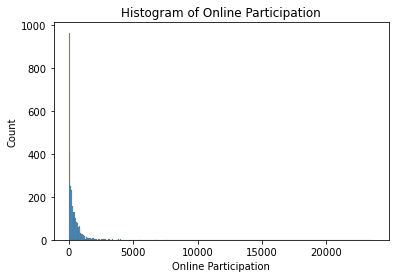

In [16]:
# Plot the target
ax = sns.histplot(df.sum_weighted_comments)
ax.set_title('Histogram of Online Participation')
ax.set_xlabel('Online Participation')
#plt.savefig('output.png', dpi=300)

Text(0.5, 0, 'Online Participation')

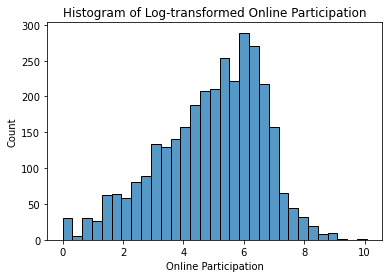

In [17]:
# Plot log transformation of the target
ax = sns.histplot(np.log1p(df.sum_weighted_comments))
ax.set_title('Histogram of Log-transformed Online Participation')
ax.set_xlabel('Online Participation')
#plt.savefig('output1.png', dpi=300)

In [18]:
# Create log transformed version of target
df['sum_weighted_comments_log'] = np.log1p(df.sum_weighted_comments)
# Look at the highest correlations with target
df.corr().sum_weighted_comments_log.abs().sort_values(ascending=False).head(10)

sum_weighted_comments_log            1.000000
sum_weighted_comments                0.574313
channel_NPO 1                        0.546404
channel_NPO 2                        0.545951
pageViewsTotal                       0.533528
avg_kdh                              0.504010
ownPostsComments                     0.503287
first_broadcaster_AVTR               0.483188
title_Eenvandaag                     0.440784
skoClassL2_NIEUWS & ACTUALITEITEN    0.400824
Name: sum_weighted_comments_log, dtype: float64

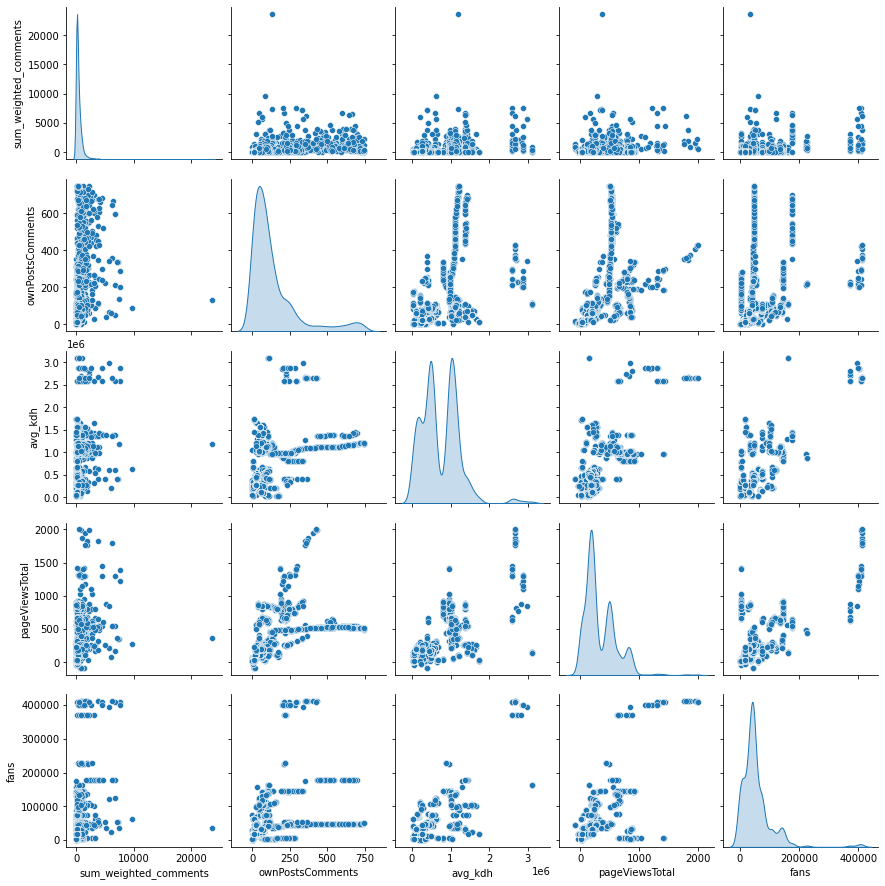

In [19]:
sns.pairplot(df[['sum_weighted_comments','ownPostsComments', 'avg_kdh', 'pageViewsTotal', 'fans']], diag_kind='kde')

In [20]:
df = df.drop('sum_weighted_comments_log',axis=1)

## Saving the DataFrame

In [21]:
# Save the transformed df
df_tosave = df.copy()
df_tosave['ID'] = ids
df_tosave.to_csv('main.csv')

## Baseline Model

In [22]:
# Get the dfs of X and y
X_df = df.drop("sum_weighted_comments", axis=1)
y_df = df.sum_weighted_comments
# Get the numpy arrays
X = X_df.values
y = y_df.values
# Log-transform y
y = np.log1p(y)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44)

In [24]:
cv = KFold(n_splits=5, shuffle=True, random_state=55)

In [25]:
def score(model, X_train, X_test, y_train, y_test, cv):
    model.fit(X_train, y_train)
    print("Train R^2: {:0.4}".format(model.score(X_train, y_train)))
    print("CV R^2: {:0.4}".format(cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()))
    print("Test R^2: {:0.4}".format(model.score(X_test, y_test)))

In [26]:
lr = LinearRegression()
score(lr, X_train, X_test, y_train, y_test, cv)

Train R^2: 0.6807
CV R^2: 0.6405
Test R^2: 0.642


## Missing Data Analysis

In [27]:
df_missing['sm_na'] = df_missing.ownPostsEngagementRate.isnull().astype('int')

df_missing = df_missing.drop(['ownPostsEngagementRate','pageImpressionsPaidUnique','pageViewsTotal','pageEngagementRateUnique'], axis=1)
df_missing = df_missing.dropna()
df_missing = pd.get_dummies(df_missing)
y_na = df_missing.sm_na.values
X_na = df_missing.drop('sm_na',axis=1).values

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_na, y_na, test_size=0.25, random_state=44)

In [29]:
logreg_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=10000))
logreg_pipe.fit(X_train,y_train)
print(logreg_pipe.score(X_test,y_test))

df_r = pd.DataFrame(logreg_pipe[1].coef_).T
df_r.columns = ['coef']

0.916354556803995


# Lemmatizing

## Imports

In [30]:
import pandas as pd
import spacy
import numpy as np
from nltk.corpus import stopwords
from gensim.corpora import Dictionary
import pickle

## Merging Subtitles

In [31]:
df_s = pd.read_csv('subtitles.csv')
df_s = df_s.drop_duplicates('ID')

df_m = pd.read_csv('query.csv')
df_m = df_m.drop_duplicates('mediaId')

In [32]:
df_s = df_s[['ID','AggregatedText','beginTimeCET']]
df_m = df_m[['mediaId', 'AggregatedText', 'beginTimeCET']]
df_m = df_m.rename({'mediaId' : 'ID'}, axis=1)

df_s = df_s.dropna()
df_m = df_m.dropna();

In [33]:
df = df_s.append(df_m)
df = df.drop_duplicates('ID')

In [34]:
sum(df_m.ID.isin(df.ID)) == len(df_m)

True

In [35]:
df.to_csv('full_subtitles.csv')

## Processing

In [36]:
df = pd.read_csv('full_subtitles.csv')

In [37]:
df.shape

(44071, 4)

In [38]:
nlp = spacy.load("en_core_web_sm")
stopword_list = stopwords.words('dutch')
excludeword_list = ['be', 'tt888', 'informatie', 'service.npo.nl', 'jullie', 'oke', 'jij', 'ga', 'nee', 'eigenlijk', 'gewoon', 'leuk', 'vind', 'beetje', 'nou', 'lekker', 'eh', 'hee', 'zei']

subsets = []

for subset in np.array_split(df.AggregatedText, 20):
    processed_texts = [text for text in nlp.pipe(subset, 
                                                 disable=["ner",
                                                 "parser"])]
    
    lemmatized_texts = [[token.lemma_.lower() for token in text if token.lemma_.lower() not in stopword_list and 
                         token.lemma_.lower() not in excludeword_list and not token.is_punct and not token.is_digit 
                         and not token.is_space] 
                        for text in processed_texts]
    
    subsets.append(lemmatized_texts)

In [39]:
flatten = lambda t: [item for sublist in t for item in sublist]

In [40]:
df['lemmatized_text'] = flatten(subsets)

In [41]:
file = open('subs_lemmatized', 'wb')
pickle.dump(df, file)
file.close()

# Testing

In [42]:
nlp = spacy.load("en_core_web_sm")
stopword_list = stopwords.words('dutch')
excludeword_list = ['be', 'tt888', 'informatie', 'service.npo.nl']

subsets = []

for subset in np.split(df.AggregatedText[:100],2):
    processed_texts = [text for text in nlp.pipe(subset, 
                                                 disable=["ner",
                                                 "parser"])]
    
    lemmatized_texts = [[token.lemma_.lower() for token in text if token.lemma_.lower() not in stopword_list and 
                         token.lemma_.lower() not in excludeword_list and not token.is_punct and not token.is_digit 
                         and not token.is_space] 
                        for text in processed_texts]
    
    subsets.append(lemmatized_texts)

# Modeling

### Imports

In [43]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import statsmodels.api as sm
from sklearn.inspection import permutation_importance

### Import Data

In [44]:
main_df = pd.read_csv('main.csv')

In [45]:
file = open('df_topicdistributions', 'rb')
subs_df = pickle.load(file)
file.close()

In [46]:
file = open('df_topics', 'rb')
topic_df = pickle.load(file)
file.close()

### Topic DataFrame

In [47]:
pd.set_option('display.max_colwidth', None)
topic_df.iloc[:,0] = topic_df.iloc[:,0].map(lambda x: x.lstrip(','))

In [48]:
topic_df.words = topic_df.words.map(lambda x: x.rstrip(','))

In [49]:
topic_columns = ['topic0_corona_measures', 'topic1_corona_vaccine', 'topic2_locations', 'topic3_christianity', 'topic4_dutch_soccer_international', 'topic5_family', 'topic6_government', 'topic7_justice', 
 'topic8_sustainability', 'topic9_living', 'topic10_tour_de_france', 'topic11_royal_family', 'topic12_meaningless1', 'topic13_food', 'topic14_meaningless2', 'topic15_education',
 'topic16_illness', 'topic17_meaningless_3', 'topic18_gender', 'topic19_media_consumption', 'topic20_ice_skating', 'topic21_weather', 'topic22_sports', 'topic23_meaningless_4', 
 'topic24_meaningless5', 'topic25_international_relations', 'topic26_meaningless_6', 'topic27_meaningless_7', 'topic28_finance', 'topic29_meaningless_8', 'topic30_meaningless_9', 
 'topic31_business', 'topic32_politics', 'topic33_war', 'topic34_american_politics', 'topic35_china', 'topic36_protest','topic37_team_game_show', 
 'topic38_quiz_show', 'topic39_music', 'topic40_art', 'topic41_meaningless_10', 'topic42_news', 'topic43_dutch_soccer_national', 'topic44_car_accident', 'topic45_healthcare',
 'topic46_children', 'topic47_fires', 'topic48_animals', 'topic49_farmers_protest']

In [50]:
topic_df = pd.concat([pd.DataFrame(topic_columns),topic_df],axis=1)

### Joining the Topic Distributions

In [51]:
subs_df = subs_df.drop(['AggregatedText', 'beginTimeCET', 'lemmatized_text'],axis=1)

In [52]:
df = main_df.merge(subs_df, how='left', left_on='ID', right_on='ID')

In [53]:
df = df.drop(['Unnamed: 0','ID'], axis=1)

In [54]:
cols = list(df.columns[:118]) + topic_columns
df.columns = cols

### Inspecting

In [55]:
# Checking for high multicollinearity
corr_df = df.iloc[:,119:].corr()
high_mc = []
for i in np.arange(0,corr_df.shape[0]):
    for j in np.arange(0, corr_df.shape[1]):
        if corr_df.iloc[i,j] >= 0.80 and i != j:
            high_mc.append([i,j])
print(len(high_mc))

0


In [56]:
# Create log transformed version of target
df['sum_weighted_comments_log'] = np.log1p(df.sum_weighted_comments)
# Look at the highest correlations with target
corr_target = df.drop('sum_weighted_comments',axis=1).corr().sum_weighted_comments_log.abs()[:-1]

In [57]:
df = df.drop('sum_weighted_comments_log',axis=1)

### Train/Test Split

In [58]:
df.shape

(3204, 168)

In [59]:
# Get the dfs of X and y
X_df = df.drop("sum_weighted_comments", axis=1)
y_df = df.sum_weighted_comments
# Get the numpy arrays
X = X_df.values
y = y_df.values

In [60]:
# Log-transform y
y = np.log1p(y)

### Train/Test Split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=44)

### Cross-Validation and Scoring

In [62]:
cv = KFold(n_splits=5, shuffle=True, random_state=55)

In [63]:
def score(model, X_train, y_train, cv):
    model.fit(X_train, y_train)
    print("Train R^2: {:0.3}".format(model.score(X_train, y_train)))
    print("CV R^2: {:0.3}".format(cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()))
    print(' ')
    print("Train RMSE: {:0.4}".format(np.sqrt(mean_squared_error(y_train, model.predict(X_train)))))
    print("CV RMSE: {:0.4}".format(-cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error').mean()))

### Linear Regression

In [64]:
lr = LinearRegression()
score(lr, X_train, y_train, cv)

Train R^2: 0.698
CV R^2: 0.641
 
Train RMSE: 0.9662
CV RMSE: 1.052


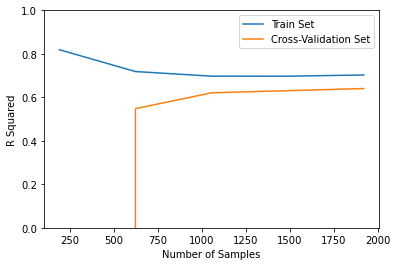

In [65]:
train_sizes, train_scores, validation_scores = learning_curve(lr, X_train, y_train, cv=cv, scoring='r2')
plt.plot(train_sizes, train_scores.mean(1))
plt.plot(train_sizes, validation_scores.mean(1))
plt.ylim([0,1])
plt.ylabel('R Squared')
plt.xlabel('Number of Samples')
plt.legend(['Train Set','Cross-Validation Set'])
plt.show()

### Ridge Regression 

In [66]:
rr_pipe = make_pipeline(StandardScaler(), Ridge(alpha=264))
score(rr_pipe, X_train, y_train, cv)

Train R^2: 0.691
CV R^2: 0.651
 
Train RMSE: 0.978
CV RMSE: 1.038


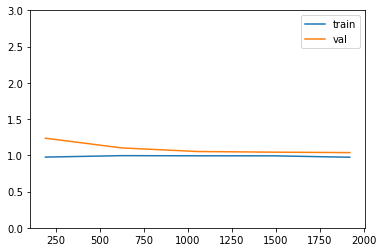

In [67]:
train_sizes, train_scores, validation_scores = learning_curve(rr_pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
plt.plot(train_sizes, -train_scores.mean(1))
plt.plot(train_sizes, -validation_scores.mean(1))
plt.ylim([0,3])
plt.legend(['train','val'])

In [68]:
#param_grid = [{'ridge__alpha': [1,10,100,200,300,400,500]}]
param_grid = [{'ridge__alpha': np.arange(250,350,1)}]
search = GridSearchCV(rr_pipe, param_grid=param_grid, cv=cv)
search.fit(X_train,y_train)
print(search.best_params_)
print(search.best_score_)

{'ridge__alpha': 264}
0.6506892086336075


### Lasso Regression

In [69]:
ls_pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.013, max_iter=5000))
score(ls_pipe, X_train, y_train, cv)

Train R^2: 0.687
CV R^2: 0.65
 
Train RMSE: 0.9834
CV RMSE: 1.039


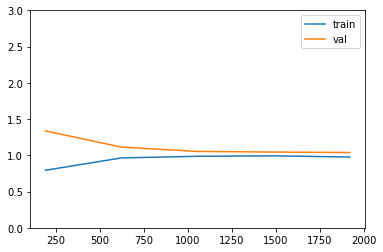

In [70]:
train_sizes, train_scores, validation_scores = learning_curve(ls_pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
plt.plot(train_sizes, -train_scores.mean(1))
plt.plot(train_sizes, -validation_scores.mean(1))
plt.ylim([0,3])
plt.legend(['train','val'])

In [71]:
#param_grid = [{'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}]
param_grid = [{'lasso__alpha': np.arange(0.001,0.02,0.001)}]
search = GridSearchCV(ls_pipe, param_grid=param_grid, cv=cv)
search.fit(X_train,y_train)
print(search.best_params_)
print(search.best_score_)

{'lasso__alpha': 0.013000000000000001}
0.6499134832959322


### Elastic Net

In [72]:
en_pipe = make_pipeline(StandardScaler(), ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=10000))
score(en_pipe, X_train, y_train, cv)

Train R^2: 0.684
CV R^2: 0.65
 
Train RMSE: 0.9878
CV RMSE: 1.038


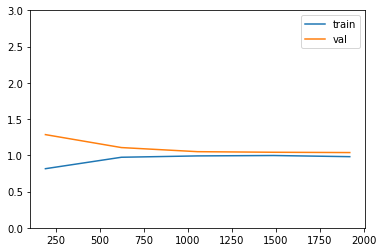

In [73]:
train_sizes, train_scores, validation_scores = learning_curve(en_pipe, X_train, y_train, cv=cv, scoring='neg_root_mean_squared_error')
plt.plot(train_sizes, -train_scores.mean(1))
plt.plot(train_sizes, -validation_scores.mean(1))
plt.ylim([0,3])
plt.legend(['train','val'])

In [74]:
#param_grid = [{'elasticnet__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0], 'elasticnet__l1_ratio': np.arange(0.0, 1, 0.1)}]
#param_grid = [{'elasticnet__alpha': [0.05, 0.01, 0.015], 'elasticnet__l1_ratio': [0.00, 0.01]}]
param_grid = [{'elasticnet__alpha': [0.05, 0.01, 0.015], 'elasticnet__l1_ratio': [0.1]}]
search = GridSearchCV(en_pipe, param_grid=param_grid, cv=cv)
search.fit(X_train,y_train)
print(search.best_params_)
print(search.best_score_)

{'elasticnet__alpha': 0.05, 'elasticnet__l1_ratio': 0.1}
0.6507916840988465


### Support Vector Regression

In [75]:
svr_pipe = make_pipeline(StandardScaler(), SVR(C=1,gamma='scale',kernel='linear'))
score(svr_pipe, X_train, y_train, cv=cv)

Train R^2: 0.686
CV R^2: 0.647
 
Train RMSE: 0.9846
CV RMSE: 1.043


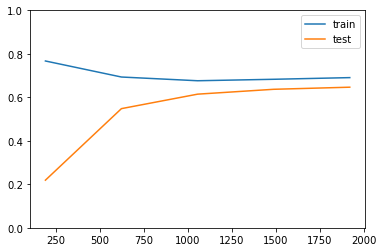

In [76]:
train_sizes, train_scores, validation_scores = learning_curve(svr_pipe, X_train, y_train, cv=cv, scoring='r2')
plt.plot(train_sizes, train_scores.mean(1))
plt.plot(train_sizes, validation_scores.mean(1))
plt.ylim([0,1])
plt.legend(['train','test'])

In [77]:
#param_grid = {'svr__C': [0.1, 1, 10], 'svr__gamma': ['scale','auto'],'svr__kernel': ['rbf','linear']}
#param_grid = {'svr__C': [0.05, 0.1, 0.15], 'svr__gamma': ['scale'],'svr__kernel': ['linear']}
param_grid = {'svr__C': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09], 'svr__gamma': ['scale'],'svr__kernel': ['linear']}
search = GridSearchCV(svr_pipe, param_grid=param_grid, cv=5)
search.fit(X_train,y_train)
print(search.best_params_)
print(search.best_score_)

{'svr__C': 0.02, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
0.6520665047205998


### Random Forest

In [78]:
rf = RandomForestRegressor(n_estimators=300, min_samples_split=2, min_samples_leaf=1, max_features='sqrt', max_depth=15, bootstrap=False, random_state=44)

score(rf, X_train, y_train, cv=cv)

Train R^2: 0.974
CV R^2: 0.672
 
Train RMSE: 0.2814
CV RMSE: 1.005


In [79]:
y_pred = rf.predict(X_test)
print(np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred))))
print(np.sqrt(mean_squared_error(y_test,y_pred)))
print(r2_score(y_test,y_pred))

485.5953660333063
0.9261780626166257
0.663925423424999


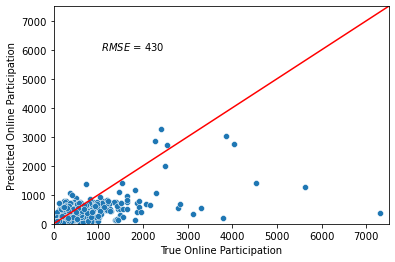

In [80]:
sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred))
plt.xlim([0,7500])
plt.ylim([0,7500])
plt.plot(np.arange(0,10000,1), 'r')
plt.xlabel('True Online Participation')
plt.ylabel('Predicted Online Participation')
plt.text(1000, 6000, r' $RMSE$ = %.f' % (430))
plt.savefig('true_vs_pred_1.png', dpi=300)

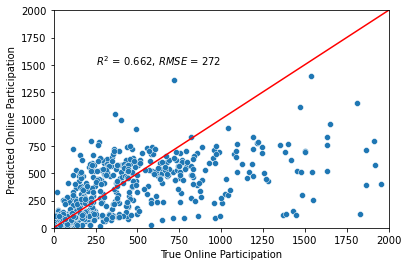

In [81]:
sns.scatterplot(x=np.expm1(y_test), y=np.expm1(y_pred))
plt.xlim([0,2000])
plt.ylim([0,2000])
plt.plot(np.arange(0,10000,1), 'r')
plt.xlabel('True Online Participation')
plt.ylabel('Predicted Online Participation')
plt.text(250, 1500, r'$R^2$ = %.3f, $RMSE$ = %.f' % (0.662, 272))
plt.savefig('true_vs_pred_1.png', dpi=300)

In [ ]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
search = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = cv, verbose=2, random_state=42, n_jobs = -1)
search.fit(X_train, y_train)
print(search.best_params_)
print(search.best_score_)

# Fitting 5 folds for each of 100 candidates, totalling 500 fits
# {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}
# 0.6746574723326675

### Feature Importances of Random Forest Model

In [84]:
fi = pd.concat([pd.DataFrame(X_df.columns),pd.DataFrame(rf.feature_importances_)],axis=1)
fi.columns = ['feature', 'importance']
fi.sort_values('importance',ascending=False).head(20)

,feature,importance
7,ownPostsComments,0.099031
10,pageViewsTotal,0.091038
3,avg_kdh,0.062312
4,fans,0.046955
64,channel_NPO 2,0.039841
11,pageEngagementRateUnique,0.035862
1,duration,0.034696
5,fansChange,0.034132
63,channel_NPO 1,0.032632
9,pageImpressionsPaidUnique,0.028994


### Extreme Gradient Boosting

In [92]:
xgb = XGBRegressor(learning_rate=0.01,
                   n_estimators=500,
                   max_depth=10,
                   subsample=0.8,
                   colsample_bytree=0.3,
                   gamma=3,
                   random_state=44)

score(xgb, X_train, y_train, cv=cv)

Train R^2: 0.904
CV R^2: 0.663
 
Train RMSE: 0.5445
CV RMSE: 1.019
